# Employee Retention

## Goal

Employee turnover is a very costly problem for companies. The cost of replacing an employee if often larger than 100K USD, taking into account the time spent to interview and find a replacement, placement fees, sign-on bonuses and the loss of productivity for several months.

It is only natural then that data science has started being applied to this area. Understanding why and when employees are most likely to leave can lead to actions to improve employee retention as well as planning new hiring in advance. This application of DS is sometimes called people analytics or people data science (if you see a job title: people data scientist, this is your job).


In this challenge, you have a data set with info about the employees and have to predict when employees are going to quit by understanding the main drivers of employee churn.


## Challenge Description

We got employee data from a few companies. We have data about all employees who joined from 2011/01/24 to 2015/12/13. For each employee, we also know if they are still at the company as of 2015/12/13 or they have quit. Beside that, we have general info about the employee, such as average salary during her tenure, department, and years of experience.
As said above, the goal is to predict employee retention and understand its main drivers


## Hints:
What are the main factors that drive employee churn? Do they make sense? Explain your findings.

What might you be able to do for the company to address employee Churn, what would be follow-up actions?

If you could add to this data set just one variable that could help explain employee churn, what would that be?

Your output should be in the form a a jupyter notebook and pdf output of a jupyter notebook in which you specify your results and how you got them.

## Data

The table is:

"employee_retention" - comprehensive information about employees.
Columns:

employee_id : id of the employee. Unique by employee per company 

company_id : company id. 

dept : employee department 

seniority : number of yrs of work experience when hired 

salary: average yearly salary of the employee during her tenure within the company 

join_date: when the employee joined the company, it can only be between 2011/01/24 and 2015/12/13 

quit_date: when the employee left her job (if she is still employed as of 2015/12/13, this field is NA)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#import data
df_emp=pd.read_csv('employee_retention.csv')

In [3]:
df_emp.head()

,Unnamed: 0,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,0,1001444.0,8,temp_contractor,0,5850.0,2008-01-26,2008-04-25
1,1,388804.0,8,design,21,191000.0,05.17.2011,2012-03-16
2,2,407990.0,3,design,9,90000.0,2012-03-26,2015-04-10
3,3,120657.0,2,engineer,20,298000.0,2013-04-08,2015-01-30
4,4,1006393.0,1,temp_contractor,0,8509.0,2008-07-20,2008-10-18


In [4]:
df_emp.dept.unique()

array(['temp_contractor', 'design', 'engineer', 'marketing',
       'customer_service', 'data_science', 'sales'], dtype=object)

# 1. Start by cleaning and exploring the data

Do we have any missing data?

In [5]:
na_list=df_emp.isna().sum()
na_list/len(df_emp) # percentage

Unnamed: 0     0.000000
employee_id    0.000000
company_id     0.000000
dept           0.000000
seniority      0.000000
salary         0.006887
join_date      0.000000
quit_date      0.322517
dtype: float64

Only the salary and quit date have NA values. The quit_dates with NA are those where employees are still employeed at that company. So, it appears 32% of employees are still employed.

I will remove rows without salary information, as missing values will not work in our models.


In [6]:
df_emp=df_emp.dropna(subset=['salary'])

Are all the values in each column reasonable?

In [7]:
df_emp.describe()

,Unnamed: 0,employee_id,company_id,seniority,salary
count,34463.000000,3.446300e+04,34463.000000,34463.000000,34463.000000
mean,17344.623538,6.476900e+05,4.026840,10.031454,100280.585004
std,10019.116656,3.338294e+05,2.912295,9.359584,87322.502536
min,0.000000,3.600000e+01,1.000000,0.000000,5000.000000
25%,8662.500000,3.546315e+05,1.000000,0.000000,9302.000000
50%,17338.000000,7.081990e+05,3.000000,8.000000,88000.000000
75%,26020.500000,1.001384e+06,6.000000,18.000000,158000.000000
max,34701.000000,1.009999e+06,12.000000,99.000000,408000.000000


They all seem reasonable, except where seniority is at the max of 99. This would mean that person had 99 years experience when they joined the company. Let's look at this column further.

In [8]:
#entries where experience in years is above 30
df_emp[df_emp['seniority']>30]

,Unnamed: 0,employee_id,company_id,dept,seniority,salary,join_date,quit_date
23683,23683,97289.0,10,engineer,98,266000.0,2011-12-13,2015-01-09
26543,26543,604052.0,1,marketing,99,185000.0,2011-07-26,2013-12-06


There are only 2 people with errouneous seniority, so we will remove these 2.

In [9]:
df_emp=df_emp[df_emp['seniority']<30]

Text(0, 0.5, 'Frequency')

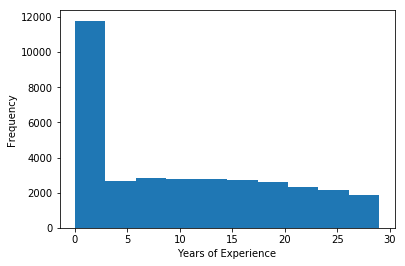

In [10]:
plt.hist(df_emp['seniority'])
plt.xlabel("Years of Experience")
plt.ylabel("Frequency")

This dataset looks a bit unbalanced, with more ppl with less experience.

What about the join and quit date years, do these look correct?

In [11]:
#need to convert timestamp column into actual timestamp, currently it is an object
df_emp['join_date']=pd.to_datetime(df_emp['join_date'])
df_emp['quit_date']=pd.to_datetime(df_emp['quit_date'])


yes, the dates look fine

In [12]:
#count how many people joined on each day
group_join_day=df_emp.groupby('join_date', as_index=False)['employee_id'].count()

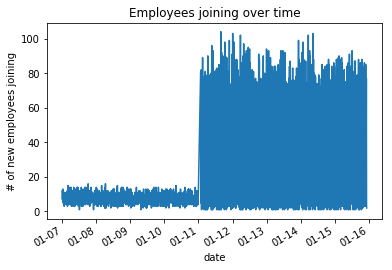

In [13]:
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots()
ax.plot(group_join_day['join_date'], group_join_day['employee_id'])
myFmt = DateFormatter("%m-%y")
ax.xaxis_date()
ax.xaxis.set_major_formatter(myFmt)

## Rotate date labels automatically
fig.autofmt_xdate()


plt.ylabel('# of new employees joining')
plt.xlabel('date')
plt.title('Employees joining over time')
plt.show()

The problem statement says we are only concerned with dates beginning in 2011. I am not sure why we have dates going back to 2007, but I will remove these from the dataset as they also seem to have far less hires.

In [14]:
df_emp=df_emp[(df_emp['join_date']>'2011-01-24') & (df_emp['join_date']<'2015-12-13')]
df_emp=df_emp[(df_emp['quit_date']>'2011-01-24') | (df_emp['quit_date'].isna())]

In [15]:
df_emp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24380 entries, 1 to 34701
Data columns (total 8 columns):
Unnamed: 0     24380 non-null int64
employee_id    24380 non-null float64
company_id     24380 non-null int64
dept           24380 non-null object
seniority      24380 non-null int64
salary         24380 non-null float64
join_date      24380 non-null datetime64[ns]
quit_date      13296 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(3), object(1)
memory usage: 1.7+ MB


The dataset is now much smaller, at about 24,000 entries compared to 34,000 when we started.

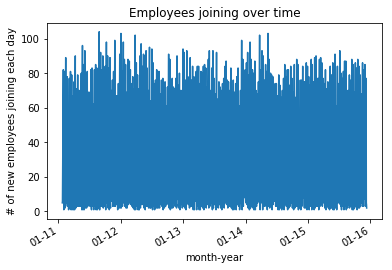

In [16]:
#count how many people joined on each day
group_join_day=df_emp.groupby('join_date', as_index=False)['employee_id'].count()

fig, ax = plt.subplots()
ax.plot(group_join_day['join_date'], group_join_day['employee_id'])
myFmt = DateFormatter("%m-%y")
ax.xaxis_date()
ax.xaxis.set_major_formatter(myFmt)

## Rotate date labels automatically
fig.autofmt_xdate()

plt.ylabel('# of new employees joining each day')
plt.xlabel('month-year')
plt.title('Employees joining over time')
plt.show()

It looks like hiring has generally remained steady from 2011 to 2015.

# 2. Feature Engineering

In [17]:
#Let's create a year and month column so we can group by these variables
df_emp['join_month']=df_emp['join_date'].apply(lambda x: x.month)
df_emp['quit_month']=df_emp['quit_date'].apply(lambda x: x.month)
df_emp['join_year']=df_emp['join_date'].apply(lambda x: x.year)
df_emp['quit_year']=df_emp['quit_date'].apply(lambda x: x.year)

Create the quit or retained column "retained", if value=0 then that person quit, if value=1 then that person is still employeed with the company.

In [18]:
df_emp['retained']=np.where(df_emp['quit_date'].isna(), 1, 0)

Create a total time on job column (diff between start and end date), if no end date then use the most recent date b/c that person is still employed.

In [19]:
pd.to_datetime('2015-12-13')-df_emp['join_date'][1]

Timedelta('1671 days 00:00:00')

In [20]:
df_emp['days_emp']=np.where(df_emp['quit_date'].notna(), (df_emp['quit_date']-df_emp['join_date']), (pd.to_datetime('2015-12-13')-df_emp['join_date']))
df_emp['days_emp']=df_emp['days_emp'].apply(lambda x: x.days)

Create feature: total days employee could have been employeed if they had not quit (b/c ppl joined at different times, a strict 'days' counter may not reflect their experience).
This is the total number of days prior to 2015-12-13 (the most recent data), when that person was hired.
So if the person was hired on 2015-11-13 this column would show '30' for 30 days.

In [21]:
df_emp['days_since_hire']=(pd.to_datetime('2015-12-13')-df_emp['join_date'])
df_emp['days_since_hire']=df_emp['days_since_hire'].apply(lambda x: x.days)

#percentage of actual days employeed / total days possible
df_emp['percent_employed']=(df_emp['days_emp']/df_emp['days_since_hire'])*100

In [22]:
df_emp.head()

,Unnamed: 0,employee_id,company_id,dept,seniority,salary,join_date,quit_date,join_month,quit_month,join_year,quit_year,retained,days_emp,days_since_hire,percent_employed
1,1,388804.0,8,design,21,191000.0,2011-05-17,2012-03-16,5,3.0,2011,2012.0,0,304,1671,18.192699
2,2,407990.0,3,design,9,90000.0,2012-03-26,2015-04-10,3,4.0,2012,2015.0,0,1110,1357,81.798084
3,3,120657.0,2,engineer,20,298000.0,2013-04-08,2015-01-30,4,1.0,2013,2015.0,0,662,979,67.620020
5,5,287530.0,5,marketing,20,180000.0,2014-06-30,NaT,6,NaN,2014,NaN,1,531,531,100.000000
6,6,561043.0,3,customer_service,18,119000.0,2012-07-02,2014-03-28,7,3.0,2012,2014.0,0,634,1259,50.357427


Text(0.5, 0, 'date employee joined')

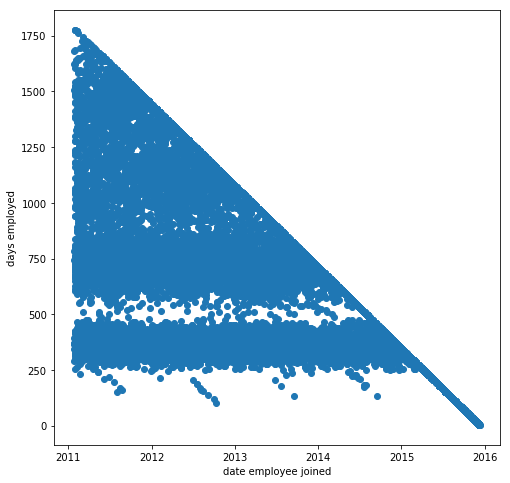

In [23]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot_date(x=df_emp['join_date'], y=df_emp['days_emp'], marker='o')
plt.ylabel('days employed')
plt.xlabel('date employee joined')

Interestingly, it appears anyone who joined after 2015 stayed with the company b/c the dots are all on the diagonal line for the max number of days that person could stay based on their starting date.

Can we create groups for seniority or salary levels to help us with our predictions?

In [24]:
df_emp['group_seniority']=np.where(df_emp['seniority']<5, 'a. 0-4',
                        np.where((df_emp['seniority']>=5) & (df_emp['seniority']<10), 'b. 5-9',
                                np.where((df_emp['seniority']>=10) & (df_emp['seniority']<15), 'c. 10-14', 
                                        np.where((df_emp['seniority']>=15) & (df_emp['seniority']<20), 'd. 15-19',
                                            np.where((df_emp['seniority']>=20) & (df_emp['seniority']<25), 'e. 20-24',
                                                    np.where((df_emp['seniority']>=25) & (df_emp['seniority']<=30), 'f. 25-30', 'nope'))))))

In [25]:
#divide salary groups into bins with equal number of results in each bin
salarybins=pd.qcut(df_emp['salary'], 5, labels=['a. 17-70k', 'b. 70-105k', 'c. 105-145k', 'd. 145-203k', 'e. 203-408k']).astype(str)


df_emp['group_salary']=salarybins

In [26]:
#avg percent days employeed (100 = still employed)
group_seniority_mean=df_emp.groupby('group_seniority', as_index=False)[['percent_employed', 'salary', 'retained']].mean()

In [27]:
group_seniority_mean

,group_seniority,percent_employed,salary,retained
0,a. 0-4,77.370136,45293.518256,0.499858
1,b. 5-9,72.958667,118891.868880,0.429332
2,c. 10-14,73.671700,117917.209909,0.437419
3,d. 15-19,75.148221,182704.826038,0.454994
4,e. 20-24,74.291338,181880.423554,0.451446
5,f. 25-30,75.174710,182899.689441,0.469876


Overall, it looks like employees stay for a simmilar length of time (~74%) of their possible tenure, and retention rate is also simmilar across these groups (~45%) regardless of how many years experience they have.
Let's see if that changes based on department and/or company


In [28]:
group_seniority_mean_comp=df_emp.groupby(['group_seniority', 'company_id', 'dept'], as_index=False)[['percent_employed', 'salary', 'retained']].mean()
group_seniority_mean_comp.head()

,group_seniority,company_id,dept,percent_employed,salary,retained
0,a. 0-4,1,customer_service,78.179424,30091.836735,0.516327
1,a. 0-4,1,data_science,75.292654,74746.478873,0.408451
2,a. 0-4,1,design,87.582784,48984.848485,0.666667
3,a. 0-4,1,engineer,75.782993,74895.161290,0.500000
4,a. 0-4,1,marketing,75.920274,50525.000000,0.481250


/home/natalie/anaconda3/envs/insight/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/natalie/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


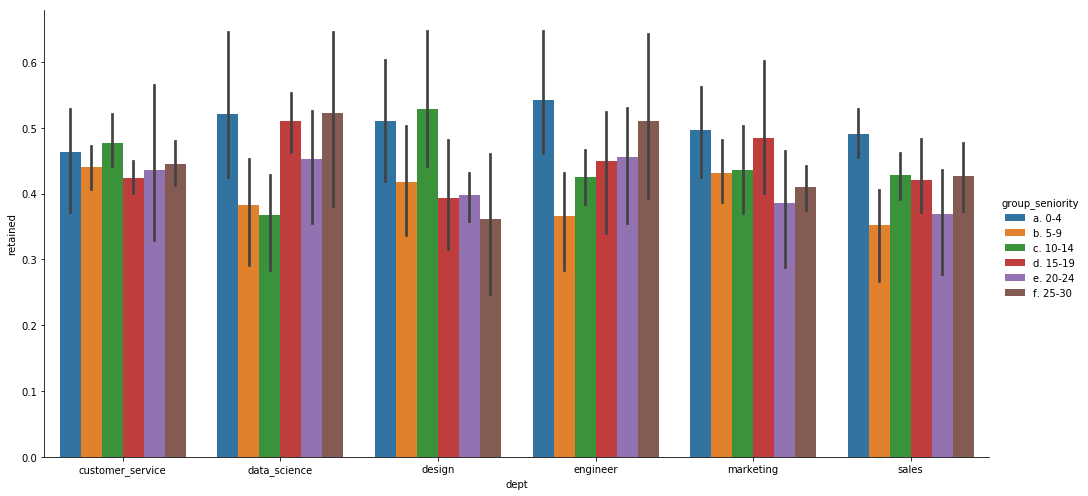

In [29]:
import seaborn as sns
sns.factorplot(x='dept', y='retained', hue='group_seniority', data=group_seniority_mean_comp, kind='bar', height=7, aspect=2)
#order=["0-4", "5-9", "10-14", "15-19", "20-24", "25-30"]

Overall, when we look at how retention rates are affected by department and the level of seniority, there is a lot of variability. Interestingly, the 0-4 year seniority group has consistently higher retention rates than the other groups. Dispelling the myth that early career goers want to jump ship.

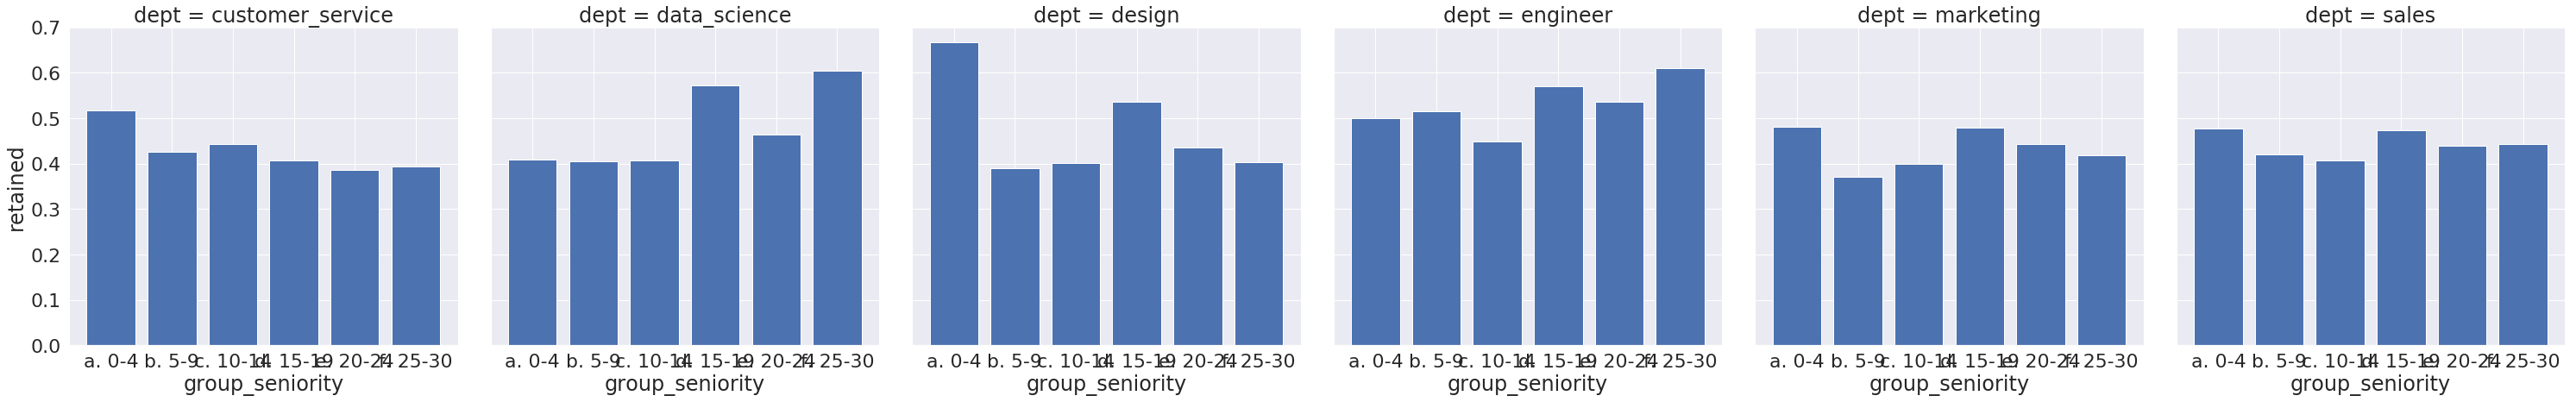

In [30]:
#example with 1 company
sns.set(font_scale=2)

g = sns.FacetGrid(group_seniority_mean_comp[group_seniority_mean_comp['company_id']==1], col = "dept", margin_titles=True, height=7, aspect=1)
g=(g.map(plt.bar, "group_seniority", "retained"))
#g.map(plt.scatter, x='group_seniority', y='retained')


### Plot overall counts of employees who stayed (retained=1) vs those who left (retained=0) based on how much seniority they had when they joined the company.

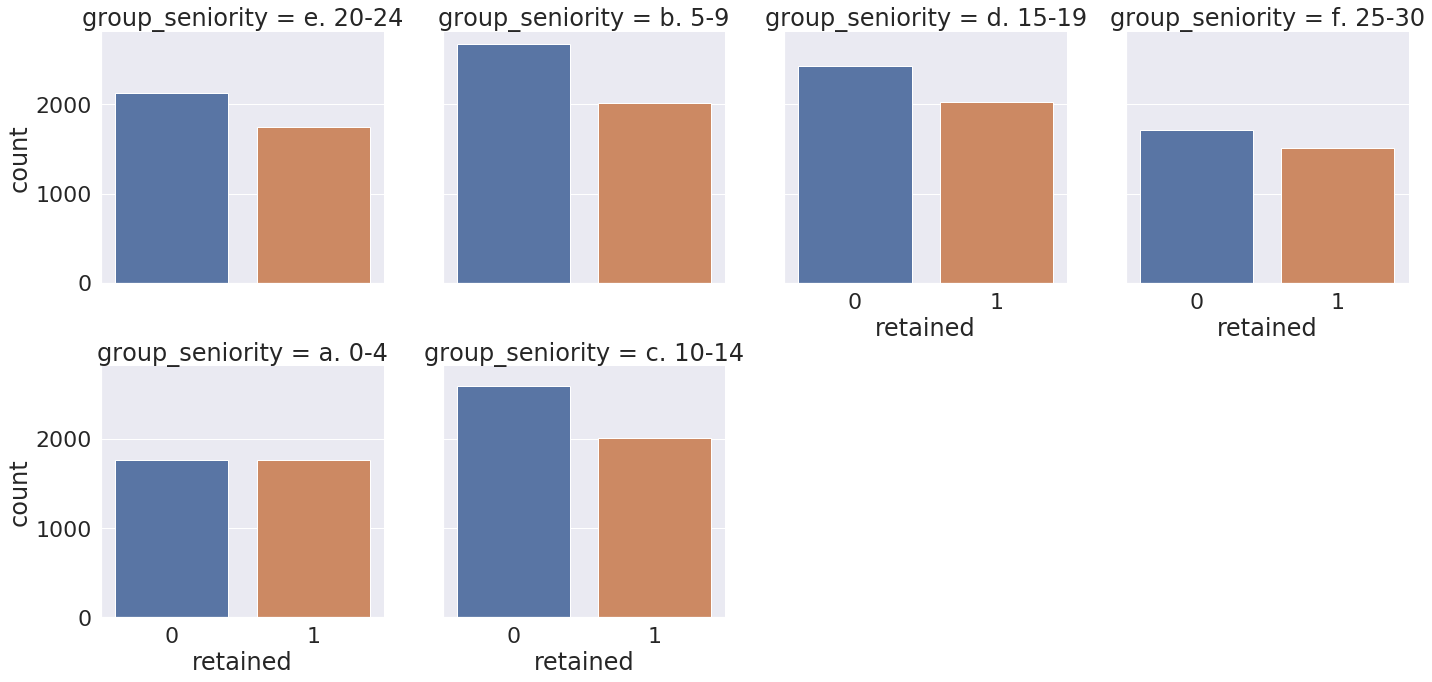

In [31]:
sns.catplot("retained", col="group_seniority", col_wrap=4,
data=df_emp, kind="count")

It appears you will always have more people leaving than staying, but the group with the most even number of ppl staying and laving is the low seniority group 0-4 years. This dispells the myth that early career goers are looking to jump ship quickly.

### Plot counts of stayed vs left depending on the salary they were hired in at

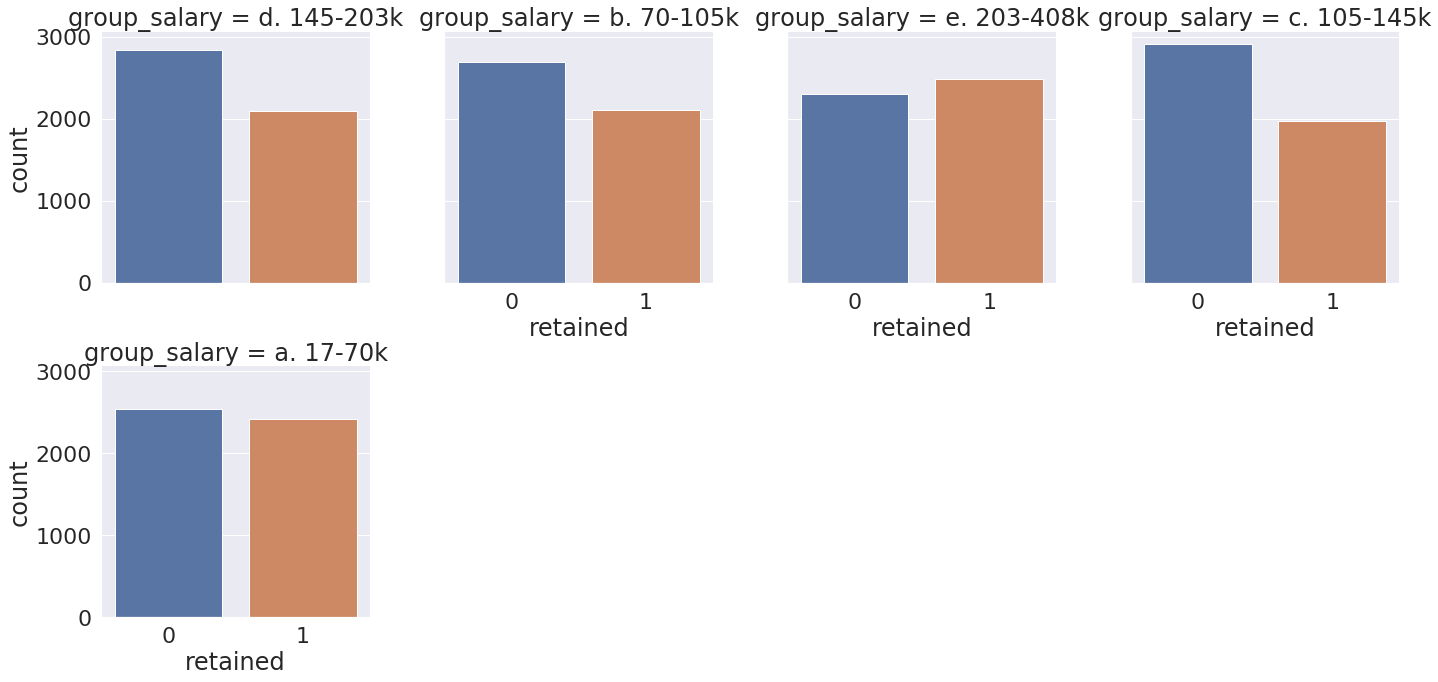

In [32]:
#salary groups and retention rate
sns.set(font_scale=2)
sns.catplot("retained", col="group_salary", col_wrap=4,
data=df_emp, kind="count")

Interestingly, the only group where the # of employees retained is greater than those who leave is the highest paying group the $205,000-$400,000 group

# 3. Predict Who will Churn

In [33]:
df_emp.head()

,Unnamed: 0,employee_id,company_id,dept,seniority,salary,join_date,quit_date,join_month,quit_month,join_year,quit_year,retained,days_emp,days_since_hire,percent_employed,group_seniority,group_salary
1,1,388804.0,8,design,21,191000.0,2011-05-17,2012-03-16,5,3.0,2011,2012.0,0,304,1671,18.192699,e. 20-24,d. 145-203k
2,2,407990.0,3,design,9,90000.0,2012-03-26,2015-04-10,3,4.0,2012,2015.0,0,1110,1357,81.798084,b. 5-9,b. 70-105k
3,3,120657.0,2,engineer,20,298000.0,2013-04-08,2015-01-30,4,1.0,2013,2015.0,0,662,979,67.620020,e. 20-24,e. 203-408k
5,5,287530.0,5,marketing,20,180000.0,2014-06-30,NaT,6,NaN,2014,NaN,1,531,531,100.000000,e. 20-24,d. 145-203k
6,6,561043.0,3,customer_service,18,119000.0,2012-07-02,2014-03-28,7,3.0,2012,2014.0,0,634,1259,50.357427,d. 15-19,c. 105-145k


### Start with logistic regression

In [34]:
## Use logistic regression and see if we can predict if the employee stays or leaves

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
# Use StandardScaler to help you standardize the dataset’s features onto unit scale (mean = 0 and variance = 1) 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

/home/natalie/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [59]:
#split up depedent and indepdent variables
X = df_emp.drop(['Unnamed: 0', 'days_emp', 'employee_id', 'retained', 'quit_month', 'quit_year', 'quit_date', 'company_id', 'dept', 'group_seniority', 'group_salary', 'join_date', 'percent_employed'], axis=1)#independent variables
#cant include percent employeed b/c this is the same thing almost as retained yes/no
Xordinal=df_emp[['company_id', 'dept', 'group_seniority', 'group_salary']]

Y=df_emp['retained'] #target variable
#company_id is numeric, but the values 1-12 do not represent anything, so we want to make a new column with the company_id as a factor

Xordinal['company_id']=Xordinal['company_id'].map({1: 'a', 2: 'b', 3:'c', 4:'d', 5:'e', 6:'f', 7:'g', 8:'h', 9:'i', 10:'j', 11:'k', 12:'l'})
#enc = OneHotEncoder(handle_unknown='ignore')
Xonehot=pd.get_dummies(Xordinal)


/home/natalie/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [60]:
#bring in the one-hot encoded categorical variables with the other numerical variables
Xonehot2=X.join(Xonehot)
Xonehot2.head()

,seniority,salary,join_month,join_year,days_since_hire,company_id_a,company_id_b,company_id_c,company_id_d,company_id_e,...,group_seniority_b. 5-9,group_seniority_c. 10-14,group_seniority_d. 15-19,group_seniority_e. 20-24,group_seniority_f. 25-30,group_salary_a. 17-70k,group_salary_b. 70-105k,group_salary_c. 105-145k,group_salary_d. 145-203k,group_salary_e. 203-408k
1,21,191000.0,5,2011,1671,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,9,90000.0,3,2012,1357,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0
3,20,298000.0,4,2013,979,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
5,20,180000.0,6,2014,531,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
6,18,119000.0,7,2012,1259,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0


In [61]:
#bring in the one-hot encoded categorical variables with the other numerical variables
Xonehot2=X.join(Xonehot)

#standadize the data so all on same scale
Xonehot_std = StandardScaler().fit_transform(Xonehot2)
Xonehot_std=pd.DataFrame(Xonehot_std)
Xonehot_std.columns=Xonehot2.columns


In [62]:
Xonehot_std.head()

,seniority,salary,join_month,join_year,days_since_hire,company_id_a,company_id_b,company_id_c,company_id_d,company_id_e,...,group_seniority_b. 5-9,group_seniority_c. 10-14,group_seniority_d. 15-19,group_seniority_e. 20-24,group_seniority_f. 25-30,group_salary_a. 17-70k,group_salary_b. 70-105k,group_salary_c. 105-145k,group_salary_d. 145-203k,group_salary_e. 203-408k
0,0.853688,0.694848,-0.446216,-1.437024,1.516200,-0.723837,-0.453779,-0.354002,-0.301376,-0.276798,...,-0.488564,-0.482372,-0.472851,2.301410,-0.390095,-0.505314,-0.495510,-0.501089,1.986261,-0.494611
1,-0.635901,-0.633325,-1.036073,-0.719322,0.903712,-0.723837,-0.453779,2.824844,-0.301376,-0.276798,...,2.046813,-0.482372,-0.472851,-0.434516,-0.390095,-0.505314,2.018124,-0.501089,-0.503458,-0.494611
2,0.729555,2.101922,-0.741144,-0.001619,0.166385,-0.723837,2.203714,-0.354002,-0.301376,-0.276798,...,-0.488564,-0.482372,-0.472851,2.301410,-0.390095,-0.505314,-0.495510,-0.501089,-0.503458,2.021793
3,0.729555,0.550196,-0.151287,0.716084,-0.707484,-0.723837,-0.453779,-0.354002,-0.301376,3.612738,...,-0.488564,-0.482372,-0.472851,2.301410,-0.390095,-0.505314,-0.495510,-0.501089,1.986261,-0.494611
4,0.481291,-0.251968,0.143642,-0.719322,0.712553,-0.723837,-0.453779,2.824844,-0.301376,-0.276798,...,-0.488564,-0.482372,2.114829,-0.434516,-0.390095,-0.505314,-0.495510,1.995652,-0.503458,-0.494611


In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(Xonehot_std, Y, test_size=0.3, random_state=0)
#X_trainstd, X_teststd, y_trainstd, y_teststd = train_test_split(Xstd, Y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
log_model=logreg.fit(X_train, y_train)

log_model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [64]:
#Let's see what people are predicted correctly
y_predLR = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.80


In [65]:
#Confusion matrix, let's examine our false positives (we erronouesly predict a school is classified as elementary),
#and our false negatives (we fail to classify a school as elementary when we should)

from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix = confusion_matrix(y_test, y_predLR)
#[True neg, False positive]Predicted along x, actual on column going down
#[False negative, True positive]

Text(0.5, 1.0, 'Logisitc Regression')

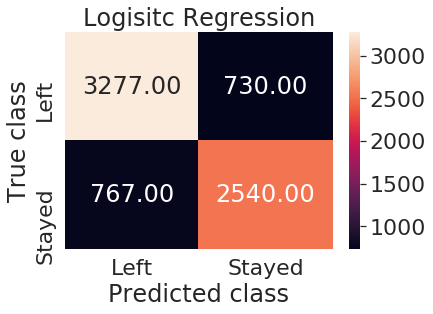

In [66]:
sns.heatmap(confusion_matrix, annot=True, fmt='.2f',xticklabels = ["Left", "Stayed"] , yticklabels = ["Left", "Stayed"] )
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('Logisitc Regression')


The confusion matrix gives an idea of how well our classifier is doing, There are 3830 correct true negatives, 177 false positives, 0 false negatives, and 3307 true positives. This means our model is performing pretty well at predicting whether or not a person will stay or leave the company.

In [67]:
print(classification_report(y_test, y_predLR))

             precision    recall  f1-score   support

          0       0.81      0.82      0.81      4007
          1       0.78      0.77      0.77      3307

avg / total       0.80      0.80      0.80      7314



This logistic regression model shows that the F1-score, an overall metric of precision and recall (ability to correctly identify true positives while minimizing false negatives and false positives) is very high, at 98%. This means our model is doing a good job.

### Let's see if we can determine what key features are driving the model, and are likely predictive of if a person stays ore leaves

By examining the standardized logistic regression coefficients, we can see which features have the most weight by looking at the absolute values (big negative values are still important).

In [68]:
coefficients = np.transpose(log_model.coef_)
xx=map(lambda x: x[0], coefficients)
coefficients=pd.Series(xx)

LRcoeff_df=pd.DataFrame(dict(feature= X_train.columns, coef=coefficients))
LRcoeff_df.head(6)

,feature,coef
0,seniority,0.244285
1,salary,0.578897
2,join_month,0.057185
3,join_year,0.697686
4,days_since_hire,-1.249413
5,company_id_a,-0.034201


In [69]:
LRcoeff_df.reindex(LRcoeff_df.coef.abs().sort_values(ascending=False).index)

,feature,coef
4,days_since_hire,-1.249413
3,join_year,0.697686
1,salary,0.578897
23,group_seniority_a. 0-4,0.370907
0,seniority,0.244285
28,group_seniority_f. 25-30,-0.197610
27,group_seniority_e. 20-24,-0.161985
29,group_salary_a. 17-70k,0.126822
26,group_seniority_d. 15-19,-0.117887
17,dept_customer_service,0.104929


# Conclusions

### top 5 features responsible for employee churn are:
    
    1. days_employed = number of days the employee has been employeed
    coefficient = 17.9, so the longer an employee stays the more likely it is they will be retained
    
    2. days_since_hire = number of days ago (from present 2015-12-13) that the employee was hired. This is a surrogate for hired date, since logistic regression cannot handle dates.
    coefficient = -14.2, the longer ago an employee was hired the more likely it is they will leave or churn. This is in opposition to 'days_employeed', which means if a person has been working for 100 days (days_employeed) but was hired 500 days ago instead of 100 days ago, they are more likely to churn if they were hired 500 days ago.
    
    3. join_year = numeric value 2011, 2012, 2013, 2014, 2015
    coefficient = 11.98, indicates the later an employee joined the more likely they are to be retained. This agrees with the 'days_since_hire' variable coefficient being negative.
    
    4. join_month = numeric value 1-12
    coefficient = 2.0, this means employees hired in the later part of the year (months near 12) are more likely to stay employeed.
    
    5. seniority = number of years employee has experience when they were hired
    coefficient = 0.35, this means the more experience they have the more likely they are to stay. Although it is a weaker coefficient (below 1).

In [531]:
df_emp_retain=df_emp[df_emp.retained==1]
df_emp_churn=df_emp[df_emp.retained==0]

Text(0.5,0,'days employed')

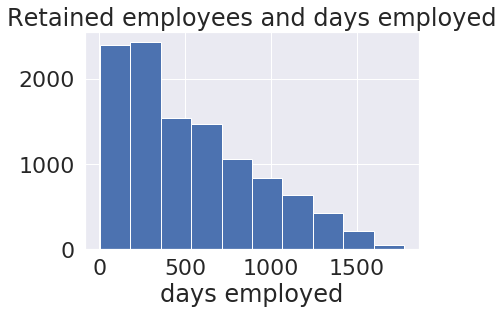

In [532]:
plt.hist(df_emp_retain['days_emp'])
plt.title('Retained employees and days employed')
plt.xlabel('days employed')

Text(0.5,0,'days employed')

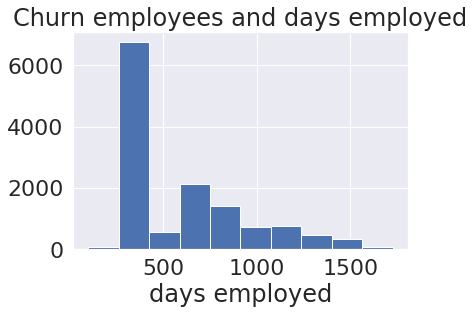

In [533]:
plt.hist(df_emp_churn['days_emp'])
plt.title('Churn employees and days employed')
plt.xlabel('days employed')

Recommendations: It appears there is no hard and fast rule for employee retention. However, employees that churn tend to do so earlier rather than later, within the first 250 days of employment. Therefore, if an employee has been there less than 1-year, it is important to check on them and make sure they are doing well.
    


### What might you be able to do for the company to address employee Churn, what would be follow-up actions?

We could now use this logistic regression model and monitor current employees, if we predict that an employee will churn, based on their profile at that point in time, we could recommend the company assess that employee's performance, and benefit package. If there is room for promotions and/or raises that may incentivise the employee to stay with the company, we could suggest these actions.

This model should be 98% accurate in prediciting employee churn, and may offer a way to reduce churn by targeting vulnerable employees before they leave.

### If you could add to this data set just one variable that could help explain employee churn, what would that be?

Adding some assessment of employee satisfaction may help us better predict who will leave and stay.